# GP emulation of univariate GlaDS ensemble

As an example of GP emulation of GlaDS outputs, including taking a Bayesian approach to GP emulation, this notebook explores emulating the spatiotemporally averaged flotation fraction as a function of 8 model inputs.

In [1]:
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import cmocean

from sepia.SepiaData import SepiaData
from sepia.SepiaModel import SepiaModel
from sepia.SepiaPredict import SepiaEmulatorPrediction

## 1 Mean flotation fraction ensemble

As a first example, we will emulate average flotation fraction as a function of the eight GlaDS parameter values, and limit to 128 training simulations.

In [2]:
m = 128

X_phys = np.loadtxt('./data/GlaDS_example/synthetic_train_physical.csv',
    delimiter=',', skiprows=1)[:m]
X_std = np.loadtxt('./data/GlaDS_example/synthetic_train_standard.csv',
    delimiter=',', skiprows=1)[:m]
X_names = np.loadtxt('./data/GlaDS_example/synthetic_train_standard.csv',
    delimiter=',', max_rows=1, dtype=str)

Y_phys = np.load('./data/GlaDS_example/synthetic_ff_mean.npy')[:m]

# Standardize the Y data
mu_y = np.mean(Y_phys)
sd_y = np.std(Y_phys)
Y = (Y_phys - mu_y)/sd_y

print(X_phys.shape)
print(X_std.shape)
print(Y_phys.shape)
print(X_names)

(128, 8)
(128, 8)
(128, 1)
['$k_{\\rm{s}}$' '$k_{\\rm{c}}$' '$h_{\\rm{b}}$' '$r_{\\rm{b}}$'
 '$l_{\\rm{c}}$' '$A$' '$\\omega$' '$e_{\\rm{v}}$']


Visualize some of the input--output combinations. Look at the first pairwise projection of the simulation data and individual scatter plots

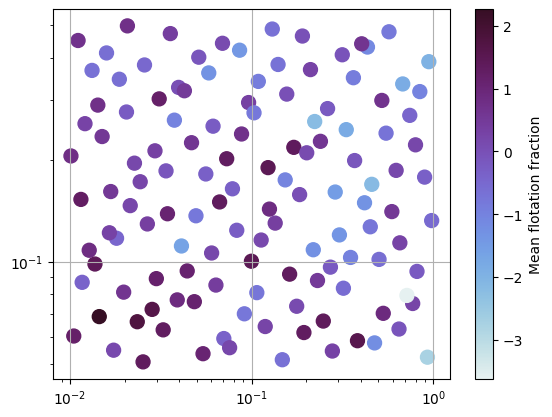

In [11]:
fig, ax = plt.subplots()
sc = ax.scatter(X_phys[:, 0], X_phys[:, 1], 100, Y, cmap=cmocean.cm.dense)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
cbar = fig.colorbar(sc)
cbar.set_label('Mean flotation fraction')

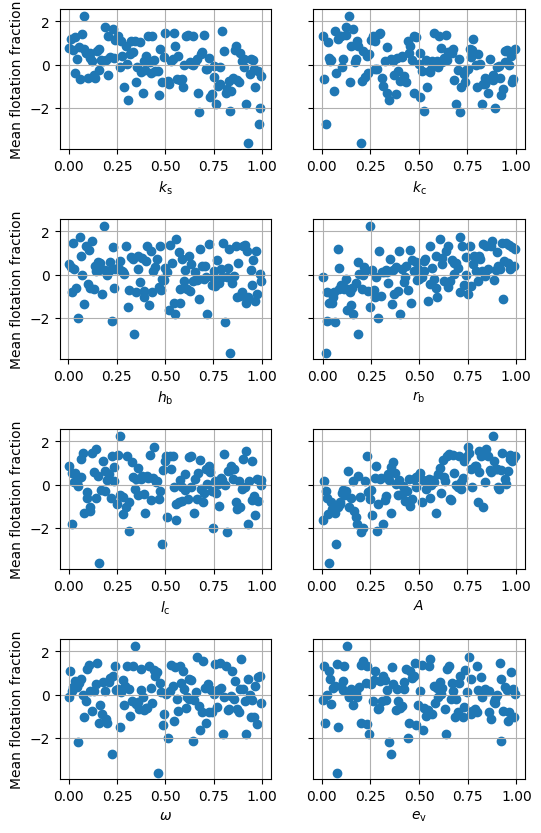

In [13]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(6, 10), sharey=True)
for i in range(X_std.shape[1]):
    axs.flat[i].scatter(X_std[:, i], Y)
    axs.flat[i].grid()
    axs.flat[i].set_xlabel(X_names[i])

for ax in axs[:, 0]:
    ax.set_ylabel('Mean flotation fraction')
fig.subplots_adjust(hspace=0.5)

## 2 GP emulator

Now we want to fit the emulator. We'll do this using the `SEPIA` package, fitting the emulator by sampling from the posterior with Metropolis MCMC. This workflow is largely based on the [SEPIA documentation](https://sepia-lanl.readthedocs.io/en/latest/snippets.html)

In [5]:
# Initialize the model instance using our X,Y data
data = SepiaData(t_sim=X_std, y_sim=Y_phys)
data.standardize_y(y_mean=mu_y, y_sd=sd_y)
ninputs = X_std.shape[1]
data.transform_xt(t_notrans=np.arange(ninputs))
print(data)

model = SepiaModel(data)

This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 1
m  =   128 (number of simulated data)
p  =     1 (number of inputs)
q  =     8 (number of additional simulation inputs)
pu =     1 (univariate response dimension)



In [6]:
# Tune step sizes to improve MCMC efficiency
model.tune_step_sizes(100, 5)

Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]]
lamUz
[[5.]]
lamWs
[[100.]]
lamWOs
[[100.]]


Step size tuning: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.03it/s]

Done with tune_step_size.
Selected step sizes:
betaU
[[0.234592  ]
 [0.1877632 ]
 [0.12045707]
 [0.09713351]
 [0.18087468]
 [0.00256842]
 [0.08164724]
 [0.01345168]
 [0.02190514]]
lamUz
[[0.01275258]]
lamWs
[[1505.35326549]]
lamWOs
[[1783.95448229]]


In [7]:
# Do the MCMC, draw lots of samples
model.do_mcmc(2048)

MCMC sampling: 100%|████████████████████████████████████████████████████████████████| 2048/2048 [00:22<00:00, 91.02it/s]


### Evaluate the MCMC samples

It's important to evaluate the MCMC samples. SEPIA also has some built-in tools for this. Here we look at the trace for each GP hyperparameter.

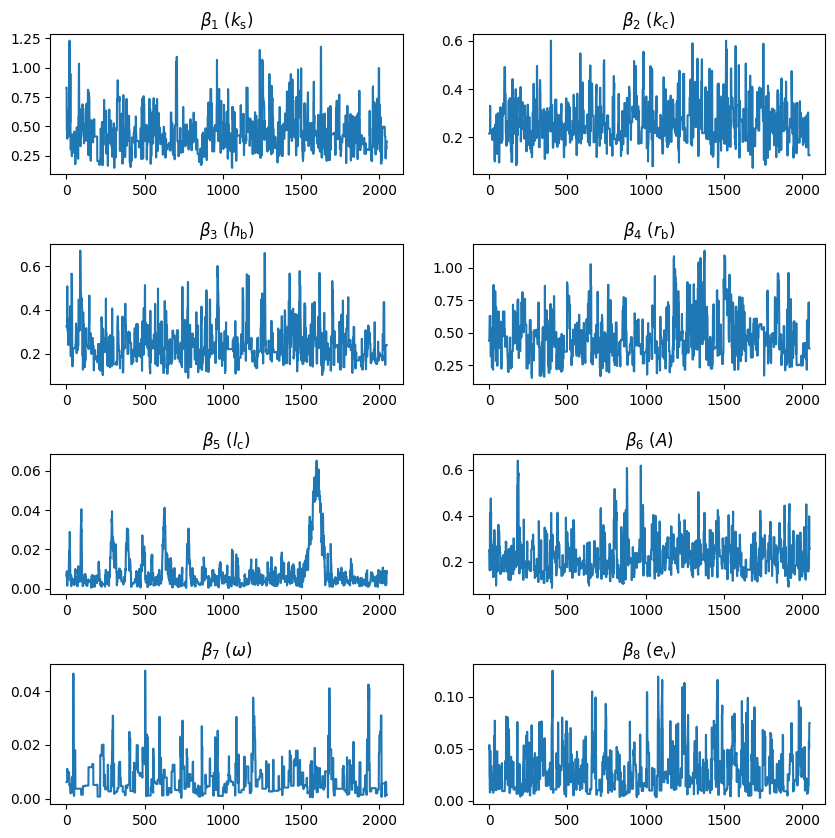

In [14]:
# Look at the MCMC traces
samples = model.get_samples()

fig,axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 10))
for i in range(1, ninputs+1):
    axs.flat[i-1].plot(samples['betaU'][:, i])
    axs.flat[i-1].set_title(r'$\beta_{}$ ({})'.format(i, X_names[i-1]))

fig.subplots_adjust(hspace=0.5)

These traces mostly look acceptable. The "fuzzy" look means they are exploring the full parameter space. The trace for $\beta_5$ ($l_{\rm{c}}$) has not fully explored its space, since it only has a few excursions to higher values. However, this parameter is small in absolute terms compared to the other coefficients, and since the scatter plot showed little sensitivity of the output (flotation fraction) to the $l_{\rm{c}}$ parameter, this is not especially concerning.

### Emulator predictions
Now we are ready to make emulator predictions for the test set. We draw 128 posterior samples from the full MCMC chain and draw emulator predictions for each of these samples.

In [9]:
# Read in the test data and test input settings
X_test_phys = np.loadtxt('./data/GlaDS_example/synthetic_test_physical.csv',
    delimiter=',', skiprows=1)[:m]
X_test_std = np.loadtxt('./data/GlaDS_example/synthetic_test_standard.csv',
    delimiter=',', skiprows=1)[:m]

Y_test = np.load('./data/GlaDS_example/test_mean.npy')

# Make emulator predictions using a subset of these samples
post_samples = model.get_samples(numsamples=128, nburn=256)

emulator_preds = SepiaEmulatorPrediction(t_pred=X_test_std, 
    samples=post_samples, model=model)

y_preds = emulator_preds.get_y()

# Compute mean and quantiles of prediction
y_pred_mean = np.mean(y_preds, axis=0)
y_pred_lq = np.quantile(y_preds, 0.025, axis=0)
y_pred_uq = np.quantile(y_preds, 0.975, axis=0)

-0.00021012802281550336
-0.00028133394033048425


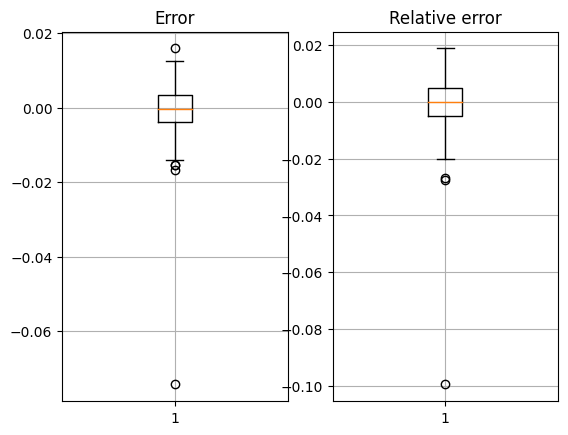

In [10]:
# Evaluate the predictions
pred_error = y_pred_mean - Y_test
rel_error = pred_error/Y_test

fig, axs = plt.subplots(ncols=2)
axs[0].boxplot(pred_error)
axs[0].set_title('Error')
axs[0].grid()

axs[1].boxplot(rel_error)
axs[1].set_title('Relative error')
axs[1].grid()

print(np.median(pred_error))
print(np.median(rel_error))

These predictions are quite good! The error is mostly within $\pm 2\%$, with a single outlier where the emulator under-predicts by 10%. The emulator has minimal bias (i.e., median relative error is $<0.1\%$). The next notebook extends this approach to multivariate model outputs.